# Analyse des revenus des films au box-office

## Final Project Submission

Please fill out:
* Student name: Christie Feliza Maguelonne Anilus
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: Jerome WEDTER
* Blog post URL:https://github.com/Christie-Anilus/box-office-analysis


## Objectif du projet
L’objectif de ce projet est d’analyser les revenus des films au box-office américain.  
Nous voulons identifier les genres de films les plus rentables et comprendre les facteurs de succès.

Nous utilisons des données CSV (`bom.movie_gross.csv`) et une base SQLite (`im.db`) pour croiser les revenus, les genres, et les scores.

## Données utilisées 
- **bom.movie_gross.csv** : contient les revenus domestiques et internationaux des films
- **im.db** : base de données SQLite avec les titres, genres, et notes des films

Nous allons fusionner ces deux sources pour faire une analyse complète.

## Préparation de l'environnement
Avant d’analyser les données, nous importons les bibliothèques nécessaires : Pandas, NumPy, Matplotlib, Seaborn et sqlite3.

In [1]:
# Your code here - remimport pandas as pd
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Options pour mieux afficher les données
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Chargement des revenus box office
box_office = pd.read_csv("bom.movie_gross.csv")

# Vérification des colonnes
print(box_office.columns)
box_office.head()

Index(['title', 'studio', 'domestic_gross', 'foreign_gross', 'year'], dtype='object')


,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


# Nettoyage des données
Nous analysons les valeurs manquantes et remplaçons celles-ci par 0.  
Nous filtrons aussi les lignes ou colonnes avec plus de 50% de données manquantes.

In [2]:
# Chargement du fichier CSV
df = pd.read_csv("bom.movie_gross.csv")

#  Nombre total de lignes et de colonnes avant nettoyage
print("\n Dimensions du fichier :")
print(f"Nombre de lignes : {df.shape[0]}")
print(f"Nombre de colonnes : {df.shape[1]}")

nb_lignes_a_erreur = df[df.isnull().any(axis=1)].shape[0]
print(f"\n Nombre de lignes avec au moins une valeur manquante : {nb_lignes_a_erreur}")

# On remplace les valeurs manquantes par 0
df.fillna(0, inplace=True)


 Dimensions du fichier :
Nombre de lignes : 3387
Nombre de colonnes : 5

 Nombre de lignes avec au moins une valeur manquante : 1380


In [3]:
# Vérification des colonnes
print(df.columns)
df.head()

Index(['title', 'studio', 'domestic_gross', 'foreign_gross', 'year'], dtype='object')


,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [4]:
print("\n Informations sur les colonnes :")
print(df.info())


 Informations sur les colonnes :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3387 non-null   object 
 2   domestic_gross  3387 non-null   float64
 3   foreign_gross   3387 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB
None


In [5]:
# Suppression des lignes ayant plus de 50% de NaN
seuil = 0.5  # seuil de 50%
df_clean = df[df.isnull().mean(axis=1) < seuil]
print(f"Nombre de lignes restantes : {df_clean.shape[0]}")
# Suppression des colonnes ayant plus de 50% de NaN
df_clean = df.loc[:, df.isnull().mean(axis=0) < seuil]
print(f"Nombre de colonnes : {df_clean.shape[1]}")

Nombre de lignes restantes : 3387
Nombre de colonnes : 5


# Connexion à la base de données IMDB
Nous ouvrons la base de données `im.db` et extrayons les tables :  
- `movie_basics`  
- `movie_ratings`  
- `persons`

In [6]:
# Connexion à la base de données
conn = sqlite3.connect("im.db")

# Chargement des tables
movies = pd.read_sql_query("SELECT * FROM movie_basics", conn)
ratings = pd.read_sql_query("SELECT * FROM movie_ratings", conn)
persons = pd.read_sql_query("SELECT * FROM persons", conn)
principals = pd.read_sql_query("SELECT * FROM principals", conn)
writers = pd.read_sql_query("SELECT * FROM writers", conn)
movie_akas = pd.read_sql_query("SELECT * FROM movie_akas", conn)
known_for = pd.read_sql_query("SELECT * FROM known_for", conn)
directors = pd.read_sql_query("SELECT * FROM directors", conn)

# Liste des tables
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("Tables disponibles :")
print(tables)

Tables disponibles :
            name
0   movie_basics
1      directors
2      known_for
3     movie_akas
4  movie_ratings
5        persons
6     principals
7        writers


In [7]:
print(f" Valeurs manquantes dans les colonnes de la table movies:\n {(movies.isnull().mean() * 100).round(2)}")
print(f" Valeurs manquantes dans les colonnes de la table movies ratings:\n {(ratings.isnull().mean() * 100).round(2)}")
print(f" Valeurs manquantes dans les colonnes de la table persons:\n {(persons.isnull().mean() * 100).round(2)}")
print(f" Valeurs manquantes dans les colonnes de la table principals:\n {(principals.isnull().mean() * 100).round(2)}")
print(f" Valeurs manquantes dans les colonnes de la table writers:\n {(writers.isnull().mean() * 100).round(2)}")
print(f" Valeurs manquantes dans les colonnes de la table movie akas:\n {(movie_akas.isnull().mean() * 100).round(2)}")
print(f" Valeurs manquantes dans les colonnes de la table known for:\n {(known_for.isnull().mean() * 100).round(2)}")
print(f" Valeurs manquantes dans les colonnes de la table directors:\n {(directors.isnull().mean() * 100).round(2)}")

 Valeurs manquantes dans les colonnes de la table movies:
 movie_id            0.00
primary_title       0.00
original_title      0.01
start_year          0.00
runtime_minutes    21.72
genres              3.70
dtype: float64
 Valeurs manquantes dans les colonnes de la table movies ratings:
 movie_id         0.0
averagerating    0.0
numvotes         0.0
dtype: float64
 Valeurs manquantes dans les colonnes de la table persons:
 person_id              0.00
primary_name           0.00
birth_year            86.36
death_year            98.88
primary_profession     8.46
dtype: float64
 Valeurs manquantes dans les colonnes de la table principals:
 movie_id       0.00
ordering       0.00
person_id      0.00
category       0.00
job           82.72
characters    61.74
dtype: float64
 Valeurs manquantes dans les colonnes de la table writers:
 movie_id     0.0
person_id    0.0
dtype: float64
 Valeurs manquantes dans les colonnes de la table movie akas:
 movie_id              0.00
ordering           

In [8]:
# Nettoyer les titres pour faciliter la jointure
movies['primary_title'] = movies['primary_title'].str.strip().str.lower()
box_office['title'] = box_office['title'].str.strip().str.lower()

# Jointure sur le titre
merged_df = pd.merge(movies, box_office, left_on='primary_title', right_on='title', how='inner')

In [9]:
# Nombre de films dans la table 'movies'
query = "SELECT COUNT(*) FROM movie_basics;"
cursor = conn.cursor()
cursor.execute(query)
nb_films_db = cursor.fetchone()[0]
print(f"Nombre de films dans la base de données : {nb_films_db}")

Nombre de films dans la base de données : 146144


,domestic_gross,foreign_gross,total_gross
genre,,,
Sci-Fi,"106,929,563","207,885,904","330,335,596"
Adventure,"94,740,741","208,294,057","318,825,056"
Animation,"87,957,355","196,587,541","305,271,854"
Action,"58,047,648","141,988,157","220,040,026"
Fantasy,"55,279,746","138,822,567","210,406,361"
Family,"46,172,549","92,655,217","155,694,966"
Musical,"28,992,437","74,118,530","128,573,430"
Sport,"36,597,136","66,245,786","123,521,466"
Comedy,"33,596,192","71,548,857","121,945,873"


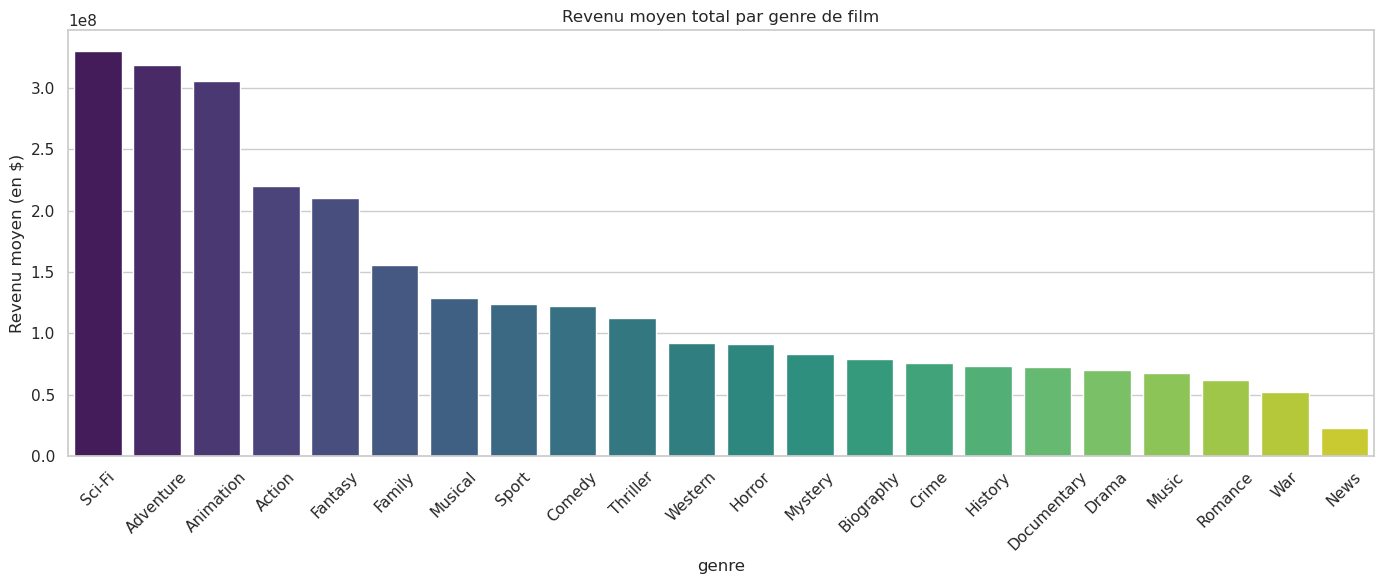

In [10]:
# Séparation des genres multiples
merged_df = merged_df.dropna(subset=["genres"])
exploded_df = merged_df.assign(genre=merged_df["genres"].str.split(',')).explode("genre")
exploded_df["genre"] = exploded_df["genre"].str.strip()

exploded_df["domestic_gross"] = pd.to_numeric(exploded_df["domestic_gross"], errors="coerce")
exploded_df["foreign_gross"] = pd.to_numeric(exploded_df["foreign_gross"], errors="coerce")

# Créer la colonne total_gross
exploded_df["total_gross"] = exploded_df["domestic_gross"] + exploded_df["foreign_gross"]

# Revenus moyens par genre
genre_gross = exploded_df.groupby("genre")[["domestic_gross", "foreign_gross", "total_gross"]].mean().sort_values(by="total_gross", ascending=False)

# Aperçu des revenus moyens par genre
pd.options.display.float_format = '{:,.0f}'.format
display(genre_gross.head(10))

#  Affichage
plt.figure(figsize=(14, 6))
sns.barplot(data=genre_gross.reset_index(), x="genre", y="total_gross", palette="viridis")
plt.title("Revenu moyen total par genre de film")
plt.ylabel("Revenu moyen (en $)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

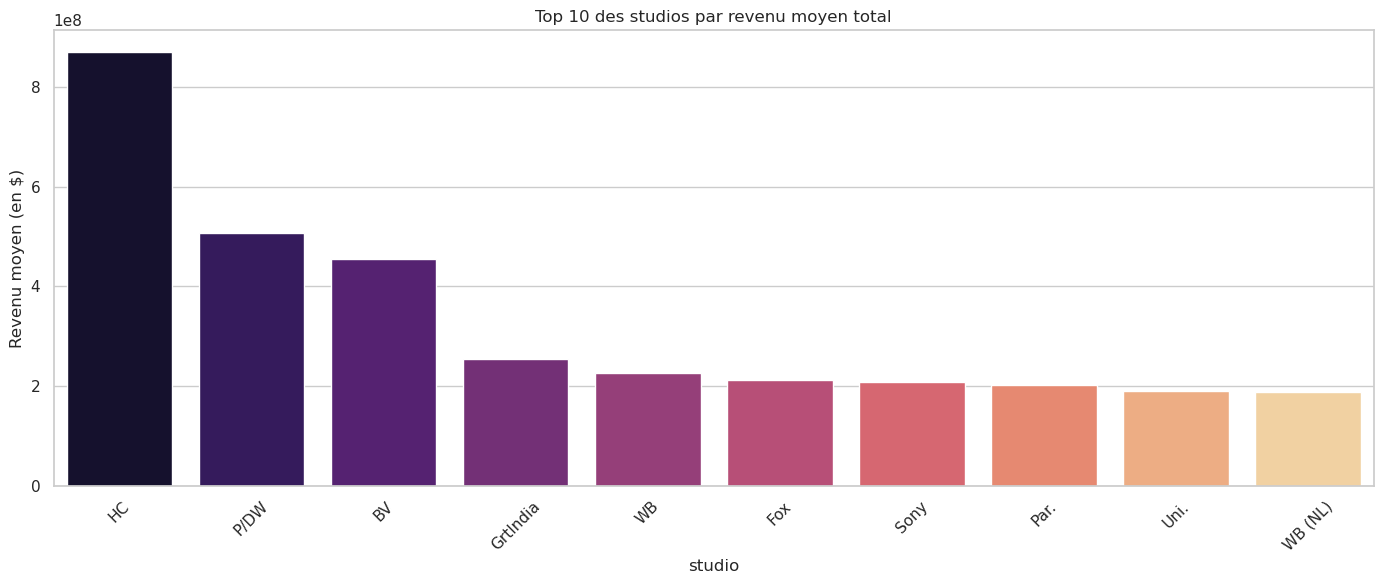

,studio,domestic_gross,foreign_gross,total_gross
0,HC,"2,700,000","867,600,000","870,300,000"
1,P/DW,"168,290,000","339,360,000","507,650,000"
2,BV,"179,550,485","275,883,313","455,479,273"
3,GrtIndia,"20,200,000","234,000,000","254,200,000"
4,WB,"88,877,612","132,413,409","225,760,654"
5,Fox,"76,088,312","134,124,944","211,524,282"
6,Sony,"76,638,485","126,591,011","208,707,382"
7,Par.,"79,718,757","119,732,250","201,941,156"
8,Uni.,"85,868,121","109,523,978","190,404,180"
9,WB (NL),"77,921,212","109,143,077","187,946,154"


In [11]:
# Conversion en float
merged_df["domestic_gross"] = pd.to_numeric(merged_df["domestic_gross"], errors="coerce")
merged_df["foreign_gross"] = pd.to_numeric(merged_df["foreign_gross"], errors="coerce")
# Création de la colonne total_gross 
merged_df["total_gross"] = merged_df["domestic_gross"] + merged_df["foreign_gross"]

# Calcul du revenu moyen total par studio
studio_perf = merged_df.groupby("studio")[["domestic_gross", "foreign_gross", "total_gross"]].mean().sort_values(by="total_gross", ascending=False)

# Affichage graphique
plt.figure(figsize=(14, 6))
top_studios = studio_perf.head(10).reset_index()
sns.barplot(data=top_studios, x="studio", y="total_gross", palette="magma")
plt.title("Top 10 des studios par revenu moyen total")
plt.ylabel("Revenu moyen (en $)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Aperçu tabulaire
display(top_studios)


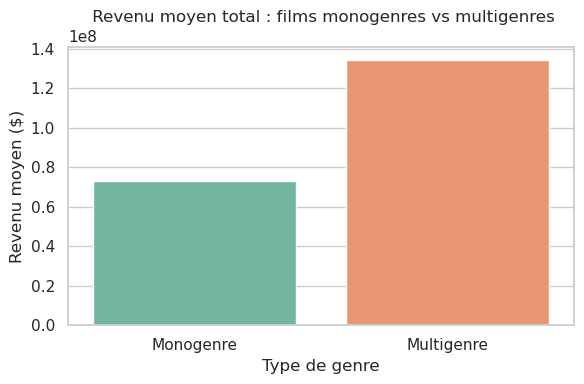

,domestic_gross,foreign_gross,total_gross
type_genre,,,
Monogenre,"16,762,220","40,039,978","72,880,262"
Multigenre,"33,758,847","82,521,982","134,321,071"


In [12]:
# Ajout d'une colonne pour compter le nombre de genres
merged_df["nb_genres"] = merged_df["genres"].str.count(",") + 1

# Création d'une étiquette : monogenre vs multigenre
merged_df["type_genre"] = merged_df["nb_genres"].apply(lambda x: "Multigenre" if x > 1 else "Monogenre")

# Calcul des performances moyennes
perf_by_genre_type = merged_df.groupby("type_genre")[["domestic_gross", "foreign_gross", "total_gross"]].mean()

# Visualisation du revenu total moyen
plt.figure(figsize=(6, 4))
sns.barplot(x=perf_by_genre_type.index, y=perf_by_genre_type["total_gross"], palette="Set2")
plt.title(" Revenu moyen total : films monogenres vs multigenres")
plt.ylabel("Revenu moyen ($)")
plt.xlabel("Type de genre")
plt.tight_layout()
plt.show()

# Affichage tableau
display(perf_by_genre_type)


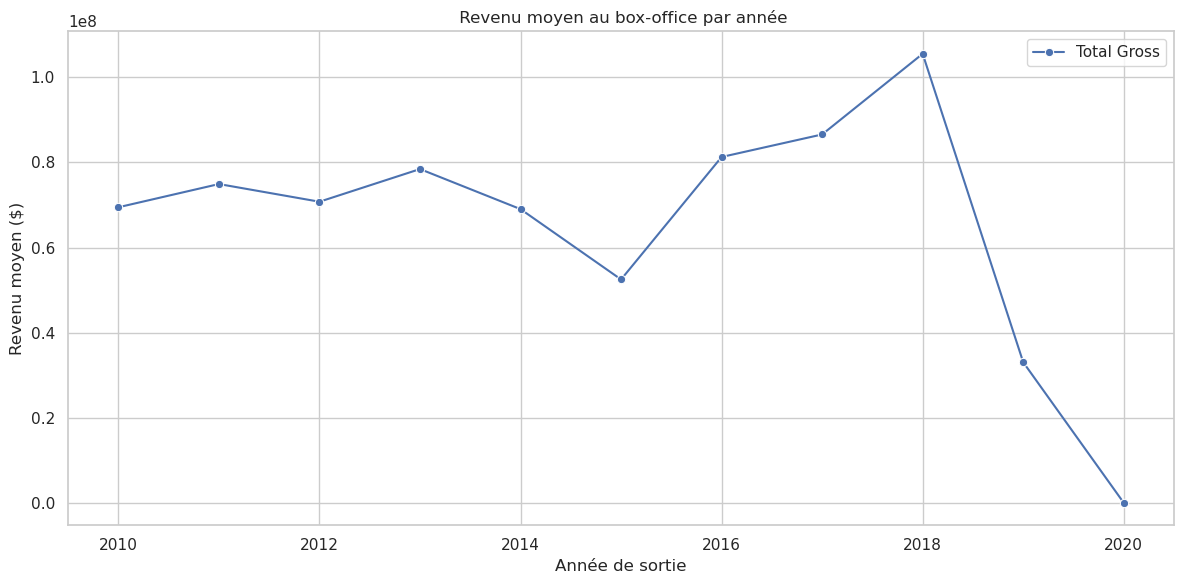

                                         title studio  domestic_gross  \
0                                  Toy Story 3     BV     415,000,000   
1                   Alice in Wonderland (2010)     BV     334,200,000   
2  Harry Potter and the Deathly Hallows Part 1     WB     296,000,000   
3                                    Inception     WB     292,600,000   
4                          Shrek Forever After   P/DW     238,700,000   

   foreign_gross  year   movie_id        primary_title  start_year  \
0    652,000,000  2010  tt0435761          Toy Story 3       2,010   
1    691,300,000  2010        NaN                  NaN         NaN   
2    664,300,000  2010        NaN                  NaN         NaN   
3    535,700,000  2010  tt1375666            Inception       2,010   
4    513,900,000  2010  tt0892791  Shrek Forever After       2,010   

    total_gross  
0 1,067,000,000  
1 1,025,500,000  
2   960,300,000  
3   828,300,000  
4   752,600,000  


In [13]:
# Lecture des colonnes pertinentes depuis la table des films
query = "SELECT movie_id, primary_title, start_year FROM movie_basics"
df_movies = pd.read_sql_query(query, conn)

# Conversion des années
df_movies["start_year"] = pd.to_numeric(df_movies["start_year"], errors="coerce")

# Fusion avec le CSV nettoyé déjà chargé sous le nom df_csv_clean
# On suppose ici que df_csv_clean est déjà propre (lignes et colonnes nettoyées)
merged_df = pd.merge(df_clean, df_movies, left_on="title", right_on="primary_title", how="left")
merged_df["domestic_gross"] = pd.to_numeric(merged_df["domestic_gross"], errors="coerce")
merged_df["foreign_gross"] = pd.to_numeric(merged_df["foreign_gross"], errors="coerce")
merged_df["total_gross"] = merged_df["domestic_gross"] + merged_df["foreign_gross"]

# Moyenne des revenus par année
yearly_revenue = merged_df.groupby("start_year")[["domestic_gross", "foreign_gross", "total_gross"]].mean().dropna()

# Visualisation
plt.figure(figsize=(12, 6))
sns.lineplot(data=yearly_revenue, x=yearly_revenue.index, y="total_gross", marker="o", label="Total Gross")
plt.title(" Revenu moyen au box-office par année")
plt.xlabel("Année de sortie")
plt.ylabel("Revenu moyen ($)")
plt.grid(True)
plt.tight_layout()
plt.show()

print(merged_df.head())

Fusion réussie. Colonnes disponibles : ['title', 'studio', 'domestic_gross', 'foreign_gross', 'year', 'total_gross', 'movie_id', 'primary_title', 'original_title', 'start_year', 'runtime_minutes', 'genres']
                        title  runtime_minutes   total_gross
0                 Toy Story 3              103 1,067,000,000
1                   Inception              148   828,300,000
2         Shrek Forever After               93   752,600,000
3  The Twilight Saga: Eclipse              124   698,500,000
4                  Iron Man 2              124   623,900,000


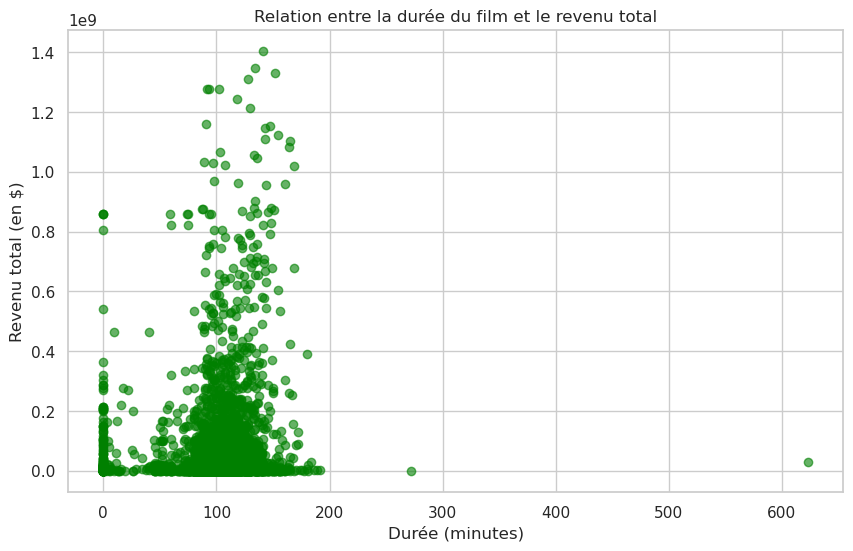

In [19]:
# Chargement de la table movie_basics
df_basics = pd.read_sql_query("SELECT * FROM movie_basics", conn)

# Nettoyage des données de la base
df_basics['runtime_minutes'] = pd.to_numeric(df_basics['runtime_minutes'], errors='coerce').fillna(0)

# Fusion des données sur les titres
merged_df = pd.merge(df_csv, df_basics, left_on="title", right_on="primary_title", how="inner")

# Vérification des colonnes fusionnées
print("Fusion réussie. Colonnes disponibles :", merged_df.columns.tolist())
print(merged_df[['title', 'runtime_minutes', 'total_gross']].head())

# Analyse : Durée vs Revenu
plt.figure(figsize=(10,6))
plt.scatter(merged_df['runtime_minutes'], merged_df['total_gross'], alpha=0.6, color='green')
plt.title("Relation entre la durée du film et le revenu total")
plt.xlabel("Durée (minutes)")
plt.ylabel("Revenu total (en $)")
plt.grid(True)
plt.show()

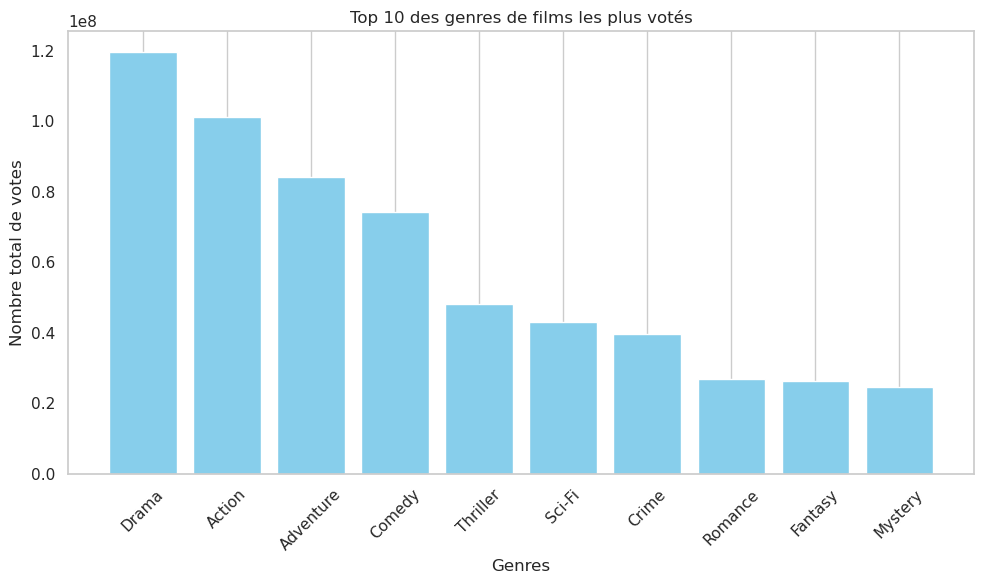

In [20]:
# Chargement des deux tables nécessaires
df_basics = pd.read_sql_query("SELECT movie_id, genres FROM movie_basics", conn)
df_ratings = pd.read_sql_query("SELECT movie_id, numvotes FROM movie_ratings", conn)

# Nettoyage des valeurs manquantes
df_basics['genres'] = df_basics['genres'].fillna("Unknown")
df_ratings['numvotes'] = pd.to_numeric(df_ratings['numvotes'], errors='coerce').fillna(0)

# Fusion des deux tables sur movie_id
merged_df = pd.merge(df_basics, df_ratings, on="movie_id", how="inner")

# Certains films ont plusieurs genres séparés par ',' on les a séparer
df_exploded = merged_df.copy()
df_exploded['genres'] = df_exploded['genres'].str.split(',')
df_exploded = df_exploded.explode('genres')

# Regroupement par genre et addition des votes
genre_votes = df_exploded.groupby('genres')['numvotes'].sum().sort_values(ascending=False).reset_index()

# Graphe
plt.figure(figsize=(10,6))
plt.bar(genre_votes['genres'][:10], genre_votes['numvotes'][:10], color='skyblue')
plt.xticks(rotation=45)
plt.title("Top 10 des genres de films les plus votés")
plt.xlabel("Genres")
plt.ylabel("Nombre total de votes")
plt.tight_layout()
plt.grid(axis='y')
plt.show()


## Recommendations
1. Investir dans les genres les plus rentables (action, aventure, science-fiction).  
2. Donner priorité aux films ayant de bonnes notes moyennes.  
3. Réévaluer les genres peu rentables pour adapter la stratégie marketing.